In [19]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
from keras.layers import Input
from keras.models import Model
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from keras.layers import Input, Dense, Conv1D, Flatten, Dropout, Bidirectional, LSTM, concatenate


In [20]:
dataset = pd.read_csv("playground-series-s4e2/train.csv")
org_dataset = pd.read_csv("obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv")

# Concatenate the two DataFrames along their rows
dataset = pd.concat([dataset, org_dataset], ignore_index=True)
dataset.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0.0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1.0,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2.0,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3.0,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4.0,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [21]:
# Dropping columns based on low std as compare to mean
columns_to_drop = ['id', 'FAF', 'TUE']
dataset = dataset.drop(columns=columns_to_drop)
dataset.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,Sometimes,Public_Transportation,Overweight_Level_II


In [22]:
# Use LabelEncoder for binary columns
binary_columns = ['Gender','family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC','NObeyesdad']
label_encoder = LabelEncoder()
for col in binary_columns:
    dataset[col] = label_encoder.fit_transform(dataset[col])

In [23]:
# One-hot encode categorical columns
categorical_columns = ['CAEC', 'CALC', 'MTRANS']
for col in categorical_columns:
    one_hot_encoded = pd.get_dummies(dataset[col], prefix=col)
    dataset = pd.concat([dataset, one_hot_encoded], axis=1)
    dataset.drop(columns=[col], inplace=True)

In [24]:
bool_columns = dataset.select_dtypes(include=['bool']).columns
dataset[bool_columns] = dataset[bool_columns].astype(int)
print(dataset.dtypes)


Gender                              int32
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight      int32
FAVC                                int32
FCVC                              float64
NCP                               float64
SMOKE                               int32
CH2O                              float64
SCC                                 int32
NObeyesdad                          int32
CAEC_Always                         int32
CAEC_Frequently                     int32
CAEC_Sometimes                      int32
CAEC_no                             int32
CALC_Always                         int32
CALC_Frequently                     int32
CALC_Sometimes                      int32
CALC_no                             int32
MTRANS_Automobile                   int32
MTRANS_Bike                         int32
MTRANS_Motorbike                    int32
MTRANS_Public_Transportation      

In [25]:
# Split data into features and target
X = dataset.drop(columns=['NObeyesdad'])
y = pd.get_dummies(dataset['NObeyesdad'])


In [26]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Apply standard scaling to numerical features after splitting
scaler = StandardScaler()
numerical_columns = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O']
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [28]:
# Define input layer
inputs = Input(shape=(X_train.shape[1],))

hidden_layer = Dense(100, activation='relu')(inputs)
hidden_layer = Dense(100, activation='relu')(hidden_layer)
hidden_layer = Dense(100, activation='relu')(hidden_layer)
hidden_layer = Dense(100, activation='relu')(hidden_layer)
outputs = Dense(y_train.shape[1], activation='softmax')(hidden_layer)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the summary of the model
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 dense_5 (Dense)             (None, 100)               2500      
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dense_8 (Dense)             (None, 100)               10100     
                                                                 
 dense_9 (Dense)             (None, 7)                 707       
                                                                 
Total params: 33,507
Trainable params: 33,507
Non-trainable

Epoch 1/200
366/366 [==============================] - 2s 3ms/step - loss: 0.5713 - accuracy: 0.7915 - val_loss: 0.4459 - val_accuracy: 0.8373
Epoch 2/200
366/366 [==============================] - 1s 3ms/step - loss: 0.3758 - accuracy: 0.8671 - val_loss: 0.4016 - val_accuracy: 0.8566
Epoch 3/200
366/366 [==============================] - 1s 3ms/step - loss: 0.3578 - accuracy: 0.8749 - val_loss: 0.3736 - val_accuracy: 0.8745
Epoch 4/200
366/366 [==============================] - 1s 4ms/step - loss: 0.3403 - accuracy: 0.8807 - val_loss: 0.3766 - val_accuracy: 0.8739
Epoch 5/200
366/366 [==============================] - 1s 3ms/step - loss: 0.3348 - accuracy: 0.8840 - val_loss: 0.3730 - val_accuracy: 0.8686
Epoch 6/200
366/366 [==============================] - 1s 3ms/step - loss: 0.3254 - accuracy: 0.8860 - val_loss: 0.3691 - val_accuracy: 0.8743
Epoch 7/200
366/366 [==============================] - 1s 3ms/step - loss: 0.3200 - accuracy: 0.8881 - val_loss: 0.3631 - val_accuracy: 0.8739

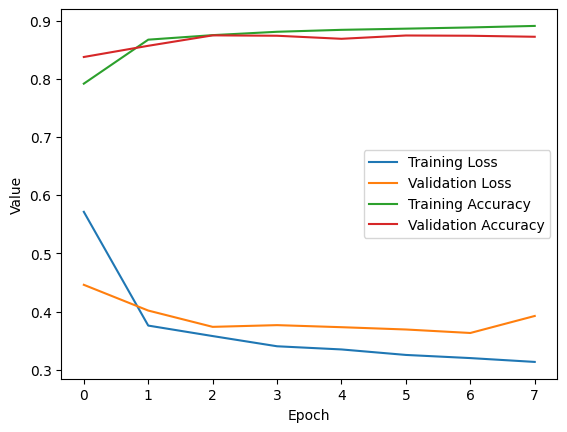

In [29]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5)

history = model.fit(X_train, y_train.values, epochs=200, batch_size=50, validation_data=(X_test, y_test.values), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [30]:
intermediate_model = Model(inputs=model.input,outputs=model.layers[-2].output)
intermediate_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 dense_5 (Dense)             (None, 100)               2500      
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dense_8 (Dense)             (None, 100)               10100     
                                                                 
Total params: 32,800
Trainable params: 32,800
Non-trainable params: 0
_________________________________________________________________


In [31]:
rf = RandomForestClassifier()
x_post_ann = intermediate_model.predict(X_train)
y_rf_train = y_train
rf.fit(x_post_ann, y_rf_train)


572/572 [==============================] - 0s 763us/step


RandomForestClassifier()

In [32]:
x_test_rf = intermediate_model.predict(X_test)
y_test_rf = y_test
y_pred = rf.predict(x_test_rf)

143/143 [==============================] - 0s 799us/step


In [33]:
print("Neural Net + RF accuracy_score:", accuracy_score(y_test_rf, y_pred))

Neural Net + RF accuracy_score: 0.865107127240927


In [34]:
from xgboost import XGBClassifier  # Import XGBClassifier

# Instantiate XGBClassifier
xgb_model = XGBClassifier()

# Fit the XGBClassifier model to the training data
xgb_model.fit(x_post_ann, y_rf_train)

# Make predictions
y_pred_xgb = xgb_model.predict(x_test_rf)

# Print accuracy score
print("Neural Net + XGBoost accuracy_score:", accuracy_score(y_test_rf, y_pred_xgb))


Neural Net + XGBoost accuracy_score: 0.8559247923043288
